In [1]:
!pip install opencv-python

  Using cached opencv_python-4.7.0.72-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.8 MB)


In [2]:
import json
import numpy as np
import cv2
import sys

from pathlib import Path
from skimage.io import imread
from tqdm import tqdm
from sklearn.neighbors import DistanceMetric
from collections import defaultdict

In [3]:
def get_central_points(mask):
    contours, _ = cv2.findContours( mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE )
    central_points = list()

    for contour in contours:
        try:
            moments = cv2.moments(contour)

            cx = int(moments['m10']/moments['m00'])
            cy = int(moments['m01']/moments['m00'])

            central_points.append([cx, cy])
        except:
            pass

    return central_points

def compute_confusion(points, pred_points, max_distance):
    if len(pred_points) == 0:
        return { 'TP': 0, 'FP': 0, 'FN': len(points) }

    euclidean = DistanceMetric.get_metric('euclidean')
    distances = euclidean.pairwise(points, pred_points)

    pairs = list()

    for tidx, _ in enumerate(points):
        for pidx, _ in enumerate(pred_points):
            pairs.append((distances[tidx][pidx], tidx, pidx))

    sorted_by_distance_pairs = sorted(pairs, key=lambda x:x[0])

    correct_pairs = defaultdict(list)
    distributed_pred = set()

    for distance, tidx, pidx in sorted_by_distance_pairs:
        if distance > max_distance:
            break
        if pidx not in distributed_pred:
            # print(tidx, pidx)
            correct_pairs[tidx].append(pidx)
            distributed_pred.add(pidx)
    # print("Pred points: ", pred_points)
    # print(len(pred_points))
    # print("Distributed pred points: ", distributed_pred)

    confusion = { 'TP': 0, 'FP': 0,  'FN': 0 }        
    confusion['FN'] = len(points) - len(correct_pairs)

    for neighbors in correct_pairs.values():
        if len(neighbors) > 1:
            confusion['FP'] += len(neighbors) - 1

        confusion['TP'] += 1
        
    for i in range(len(pred_points)):
        if i not in distributed_pred:
            confusion['FP'] += 1
    return confusion

# def draw_centers(img, x, y, radius, c, limit, rad):
#     img = cv2.circle(img, (int(x), int(y)), radius=5, color=c, thickness=12)
#     if limit:
#         img = cv2.circle(img, (int(x), int(y)), radius=int(radius), color=c, thickness=8)
#     return img
    
def detection_score(name, mask, pred_mask, distance):
    points = get_central_points(mask)
    pred_points = get_central_points(pred_mask)

    confusions = {}
    confusions = compute_confusion(points, pred_points, distance)
    
    # img = cv2.imread("../../data/all_images/" + name + ".jpg")
    # for i in points:
    #     img = draw_centers(img, i[0], i[1], distance, (255, 255, 255), True, 5)
    # for i in pred_points:
    #     img = draw_centers(img, i[0], i[1], distance, (125, 60, 195), False, 5)
    # cv2.imwrite("overlay.png", img)
    return confusions

In [7]:
def main():
    test = None

    DATA_ORG = "certain"
    GEOM = "ellipses"
    SIZE = "middle"

    with open('../make_data_organizations/splits/' + DATA_ORG + '.json', 'r') as f:
        test = json.load(f)
    test = test["test"]

    precisions = list()
    recalls = list()
    f1s = list()

    coefs = None
    ratios = None

    with open('../images_cropping/coefs.json', 'r') as f:
        coefs = json.load(f)

    with open('../images_cropping/ratios.json', 'r') as f:
        ratios = json.load(f)

    BATCHES = len(test) // 16
    REMAIN = len(test) % 16

    batch_size = 16
    for batch_count in tqdm(range(BATCHES + 1)):
        if batch_count == BATCHES:
            batch_size = REMAIN
        for i in range(batch_size):
            mask_name = str(Path(test[batch_count*16+i]).stem)
            pred_name = "output" + str(batch_count) + "_" + str(i)

            mask = imread("masks/" + mask_name + "_mask.png").clip(max=1)
            pred_mask = imread("masks/" + mask_name + "_pred.png").clip(max=1)

            distance = 3 * np.sqrt(coefs[mask_name]) / ratios[mask_name]

            confusions = detection_score(mask_name, mask, pred_mask, distance)
            # print(confusions)
            if confusions["TP"] + confusions["FP"] == 0:
                continue
            precision = confusions["TP"] / (confusions["TP"] + confusions["FP"])
            recall = confusions["TP"] / (confusions["TP"] + confusions["FN"])
            fscore = 2 * (precision*recall) / (precision+recall)
            # print(precision, recall, fscore)

            precisions.append(round(precision, 4))
            recalls.append(round(recall, 4))
            f1s.append(round(fscore, 4))
    
    print(np.mean(precisions), np.mean(recalls), np.mean(f1s))
    
#     precision, recall = detection_score(mask, pred_mask, distance)

#     if precision + recall != 0:
#         f1 = 2 * (precision*recall) / (precision+recall)
#     else:
#         f1 = 0

#     f1s.append(round(f1, 4))
#     print("\n")
    

#     print(np.mean(precisions), np.mean(recalls), np.mean(f1s))



if __name__ == "__main__":
    main()

100%|██████████| 21/21 [00:00<00:00, 24.59it/s]

0.9690981981981982 0.9614279279279279 0.9630471471471472


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
p = [0.062461781609195396, 0.2250537356321839, 0.40883793103448274, 0.5714672413793104, 0.6893477011494252, 0.769687356321839, 0.8237252873563218, 0.8593988505747125, 0.8836336206896552, 0.8962893678160918, 0.9027410919540231, 0.9117580459770114]
r = [0.053968678160919534, 0.19009022988505747, 0.34328505747126437, 0.4743295977011494, 0.5671623563218391, 0.6309965517241379, 0.6717474137931034, 0.6983399425287357, 0.7183422413793102, 0.7288189655172415, 0.7341778735632184, 0.7411252873563219]
f = [0.057383045977011486, 0.20403448275862066, 0.36938793103448275, 0.5123341954022989, 0.6143192528735631, 0.6841629310344828, 0.729260632183908, 0.7588721264367816, 0.7799238505747127, 0.7909629310344828, 0.796628735632184, 0.8041721264367816]

names = ['Precision', 'Recall', 'F-score']
colors = ['darkviolet', 'orchid', 'royalblue']
radiuses = ['0.25', '0.5', '0.75', '1', '1.25', '1.5', '1.75', '2', '2.25', '2.5', '2.75', '3']

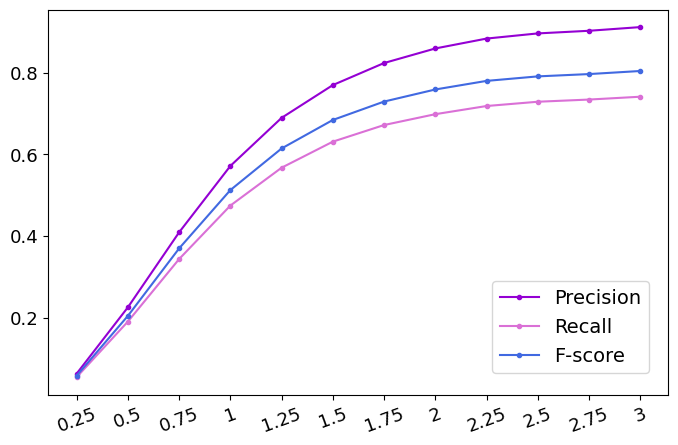

In [31]:
clsfrs = [p, r, f]

x = [i for i in range(12)]

fig = plt.figure(figsize=(8,5))
for i in range(len(clsfrs)):
    y = clsfrs[i]
    plt.plot(x, y, linestyle='-', marker='.', color=colors[i], label=names[i])
    
plt.legend(loc="upper left", bbox_to_anchor=(0.7, 0.32), fontsize=14)

plt.xticks(np.linspace(0, 3, 4))
plt.xticks(x, radiuses, rotation=20)
ax = plt.gca()
ax.tick_params(axis='both', labelsize=13)
plt.show()

In [32]:
fig.savefig("pound.png", bbox_inches='tight')